In [2]:
%matplotlib inline

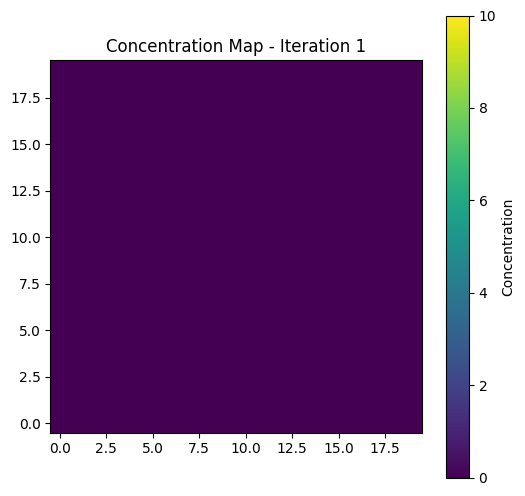

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')

#np.random.seed(42) # debug purpose
def generate_edge_land_mask(rows, cols):
    # Generate an ocean map with land around the edges
    land_mask = np.zeros((rows, cols), dtype=bool)

    # Set the edges as land
    land_mask[0, :] = True
    land_mask[-1, :] = True
    land_mask[:, 0] = True
    land_mask[:, -1] = True
    return land_mask

def generate_random_inputs(rows, cols):
    # Generate a random ocean map with initial concentration values
    ocean_map = np.zeros((rows, cols))

    # Generate land mask with land on the edges only
    land_mask = generate_edge_land_mask(rows, cols)

    # Generate S array for pollutant sources/treatment (random values as a simulation)
    # Assign negative values to simulate waste processing (cleaning up) at some random locations
    S = np.zeros((rows, cols))

    # Assign positive values to simulate pollutant sources at some random locations
    for _ in range(10):  # Adding 10 points for pollutant sources
        i, j = np.random.randint(1, rows-1), np.random.randint(1, cols-1)
        S[i, j] = 100  # Positive value for pollution

    return ocean_map, land_mask, S

def generate_random_Dx_Dy(rows, cols):
    Dx = np.random.rand(rows, cols) * 0
    Dy = np.random.rand(rows, cols) * 0
    u = np.random.randn(rows, cols) * 10
    v = np.random.randn(rows, cols) * 10
    return Dx, Dy, u, v

def update_concentration_parallel(ocean_map, land_mask, S, Dx, Dy, u, v, dt, dx, dy, iterations):
    rows, cols = ocean_map.shape
    maps_over_time = [np.copy(ocean_map)]
    for iteration in range(iterations):
        C_current = ocean_map

        # Apply the formula for C_new (vectorized)
        C_new = (
            (1 - 2 * dt * Dx / dx**2 - 2 * dt * Dy / dy**2)
        )

        # Shift land_mask for the u-direction (check neighboring cells)
        land_u_positive_shift_mask = np.roll(land_mask, -1, axis=0)  # land_mask[i+1, j]
        land_u_negative_shift_mask = np.roll(land_mask, 1, axis=0)   # land_mask[i-1, j]

        # Valid mask for u (i.e., neighbor is not land)
        land_u_mask = np.where(u > 0, land_u_positive_shift_mask, land_u_negative_shift_mask)

        # Absolute value of u but zero it out if neighbor is land
        u_term = np.where(land_u_mask > 0, 0, np.abs(u))

        # Update C_new by subtracting u_term * dt / dx
        C_new -= u_term * dt / dx

        # Shift land_mask for the v-direction (check neighboring cells)
        land_v_positive_shift_mask = np.roll(land_mask, -1, axis=1)  # land_mask[i, j+1]
        land_v_negative_shift_mask = np.roll(land_mask, 1, axis=1)   # land_mask[i, j-1]

        # Valid mask for v (i.e., neighbor is not land)
        land_v_mask = np.where(v > 0, land_v_positive_shift_mask, land_v_negative_shift_mask)

        # Absolute value of v but zero it out if neighbor is land
        v_term = np.where(land_v_mask > 0, 0, np.abs(v))

        # Update C_new by subtracting v_term * dt / dy
        C_new -= v_term * dt / dy

        # Multiply by current concentration and add pollution source
        C_new *= C_current

        # Apply the pollution source during the first half of iterations
        pollution_source = np.where(iteration < iterations / 2, S * dt, 0)
        C_new += pollution_source

        # Calculate contributions from neighboring cells (same logic as before)
        mask_x_positive = (np.roll(land_mask, -1, axis=0) == False) & (np.arange(rows) + 1 < rows)[:, np.newaxis]
        u_x_positive = np.roll(u, -1, axis=0)  # u[i+1] for x+ direction
        D_x_positive = np.roll(Dx, -1, axis=0)  # Dx[i+1] for x+ direction
        C_new = C_new + (dt / dx) * (D_x_positive / dx - np.where(u_x_positive < 0, u_x_positive, 0)) * np.roll(ocean_map, -1, axis=0) * mask_x_positive

        mask_x_negative = (np.roll(land_mask, 1, axis=0) == False) & (np.arange(rows) - 1 >= 0)[:, np.newaxis]
        u_x_negative = np.roll(u, 1, axis=0)  # u[i-1] for x- direction
        D_x_negative = np.roll(Dx, 1, axis=0)  # Dx[i-1] for x- direction
        C_new = C_new + (dt / dx) * (D_x_negative / dx + np.where(u_x_negative > 0, u_x_negative, 0)) * np.roll(ocean_map, 1, axis=0) * mask_x_negative

        mask_y_positive = (np.roll(land_mask, -1, axis=1) == False) & (np.arange(cols) + 1 < cols)[np.newaxis, :]
        v_y_positive = np.roll(v, -1, axis=1)  # v[j+1] for y+ direction
        D_y_positive = np.roll(Dy, -1, axis=1)  # Dy[j+1] for y+ direction
        C_new = C_new + (dt / dy) * (D_y_positive / dy - np.where(v_y_positive < 0, v_y_positive, 0)) * np.roll(ocean_map, -1, axis=1) * mask_y_positive

        mask_y_negative = (np.roll(land_mask, 1, axis=1) == False) & (np.arange(cols) - 1 >= 0)[np.newaxis, :]
        v_y_negative = np.roll(v, 1, axis=1)  # v[j-1] for y- direction
        D_y_negative = np.roll(Dy, 1, axis=1)  # Dy[j-1] for y- direction
        C_new = C_new + (dt / dy) * (D_y_negative / dy + np.where(v_y_negative > 0, v_y_negative, 0)) * np.roll(ocean_map, 1, axis=1) * mask_y_negative

        ocean_map = C_new

        if iteration % 100 == 0:
            maps_over_time.append(np.copy(ocean_map))
    return maps_over_time

def update_concentration(ocean_map, land_mask, S, Dx, Dy, u, v, dt, dx, dy, iterations):
    # Get the shape of the map
    rows, cols = ocean_map.shape

    # Initialize a copy of the ocean_map to store updates
    updated_map = np.copy(ocean_map)
    maps_over_time = [np.copy(ocean_map)]

    for _ in range(iterations):
        # Iterate through each cell in the ocean_map
        for i in range(rows):
            for j in range(cols):
                # Skip updating if it's a land cell
                if land_mask[i, j]:
                    continue

                # Get the current concentration value
                C_current = ocean_map[i, j]

                # Calculate the contribution from the center cell
                C_new = (1 - 2 * dt * Dx[i, j] / dx**2 - 2 * dt * Dy[i,j] / dy**2 - ((abs(u[i,j]) if not land_mask[i + (1 if u[i, j] > 0 else -1),j] else 0)  * dt / dx) - ((abs(v[i,j]) if not land_mask[i,j + (1 if v[i, j] > 0 else -1)] else 0) * dt / dy)) * C_current + (S[i, j] * dt if _ < iterations / 2 else 0)
                # Calculate contributions from neighboring cells, ensuring boundary conditions
                # if (S[i, j] > 0) :
                #     print(S[i, j])
                # x + dx
                if i + 1 < rows and not land_mask[i + 1, j]:
                    C_new += (dt / dx) * (Dx[i + 1, j] / dx - (u[i + 1, j] if u[i + 1, j] < 0 else 0)) * ocean_map[i + 1, j]
                    # C_new += (dt / dx) * (Dx_ij / dx - (u_ij / 2)) * ocean_map[i + 1, j]
                # else :
                    # C_new += (dt / dx) * (Dx_ij / dx - (u[i - 1, j] if u[i - 1, j] < 0 else 0)) * C_current

                # x - dx
                if i - 1 >= 0 and not land_mask[i - 1, j]:
                    C_new += (dt / dx) * (Dx[i - 1, j] / dx + (u[i - 1, j] if u[i - 1, j] > 0 else 0)) * ocean_map[i - 1, j]
                    # C_new += (dt / dx) * (Dx_ij / dx + (u_ij / 2)) * ocean_map[i - 1, j]
                # else :
                #     C_new += (dt / dx) * (Dx_ij / dx + (u[i - 1, j] if u[i - 1, j] > 0 else 0)) * C_current

                # y + dy
                if j + 1 < cols and not land_mask[i, j + 1]:
                    C_new += (dt / dy) * (Dy[i, j + 1] / dy - (v[i, j + 1] if v[i, j + 1] < 0 else 0)) * ocean_map[i, j + 1]
                    # C_new += (dt / dy) * (Dy_ij / dy - (v_ij / 2)) * ocean_map[i, j + 1]
                # else :
                #     C_new += (dt / dy) * (Dy_ij / dy - (v[i, j + 1] if v[i, j + 1] < 0 else 0)) * C_current

                # y - dy
                if j - 1 >= 0 and not land_mask[i, j - 1]:
                    C_new += (dt / dy) * (Dy[i, j - 1] / dy + (v[i, j - 1] if v[i, j - 1] > 0 else 0)) * ocean_map[i, j - 1]
                    # C_new += (dt / dy) * (Dy_ij / dy + (v_ij / 2)) * ocean_map[i, j - 1]
                # else :
                #     C_new += (dt / dy) * (Dy_ij / dy + (v[i, j - 1] if v[i, j - 1] > 0 else 0)) * C_current

                # Update the value in the updated_map
                updated_map[i, j] = C_new

        # Update the ocean_map for the next iteration
        ocean_map = np.copy(updated_map)
        if _ % 100 == 0:
            maps_over_time.append(np.copy(ocean_map))

    return maps_over_time

def animate_concentration(maps_over_time):
    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = 'viridis'
    cax = ax.imshow(maps_over_time[0], cmap=cmap, origin='lower', vmax=10)
    fig.colorbar(cax, ax=ax, label='Concentration')

    def update(frame):
        cax.set_data(maps_over_time[frame])
        ax.set_title(f'Concentration Map - Iteration {frame + 1}')

    return animation.FuncAnimation(fig, update, frames=len(maps_over_time), interval=1)

# Parameters
rows, cols = 20, 20  # Map size (larger to better visualize)
dt = 0.01  # Time step
dx, dy = 1.0, 1.0  # Spatial step sizes
iterations = 10000  # Number of iterations

# Generate random Dx, Dy, u, v arrays
Dx, Dy, u, v = generate_random_Dx_Dy(rows, cols)

# Generate random inputs with waste processing points
ocean_map, land_mask, S = generate_random_inputs(rows, cols)

# Update concentration and collect maps over time
maps_over_time = update_concentration(ocean_map, land_mask, S, Dx, Dy, u, v, dt, dx, dy, iterations)
#maps_over_time = update_concentration_parallel(ocean_map, land_mask, S, Dx, Dy, u, v, dt, dx, dy, iterations)
# Animate the concentration map
animation = animate_concentration(maps_over_time)

In [8]:
animation